# **LIBRARIES**

In [ ]:
import tensorflow as tf
import numpy as np
from numpy import asarray
import os
import random
import pandas as pd
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
from sklearn.metrics import confusion_matrix

from PIL import Image
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.utils import class_weight
import datetime 
import pathlib

tfk = tf.keras
tfkl = tf.keras.layers
print(tf.__version__)

2.6.4


In [ ]:
seed = 42127
random.seed(seed)
os.environ['PYTHONHASHSEED'] = str(seed)
np.random.seed(seed)
tf.random.set_seed(seed)
tf.compat.v1.set_random_seed(seed)

### Suppress warnings

In [ ]:
import warnings
import logging

os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=Warning)
tf.get_logger().setLevel('INFO')
tf.autograph.set_verbosity(0)

tf.get_logger().setLevel(logging.ERROR)
tf.get_logger().setLevel('ERROR')
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)

# **DATASET**


RGB images of 96x96 pixels.


What we would like to do is to load data in main memory to speed up processing (HOPEFULLY) 


In [ ]:
datapath = '../input/dataset/training_data_final'
training_set = tf.keras.utils.image_dataset_from_directory(
    datapath,
    labels='inferred',
    label_mode='categorical',
    class_names=None,
    color_mode='rgb',
    batch_size=32,
    image_size=(96,96),
    shuffle=True,
    seed=seed,
    validation_split=0.2,
    subset="training",
)

validation_set = tf.keras.utils.image_dataset_from_directory(
    datapath,
    labels='inferred',
    label_mode='categorical',
    class_names=None,
    color_mode='rgb',
    batch_size=32, 
    image_size=(96,96),
    seed=seed,
    validation_split=0.2,
    subset="validation",
)

AUTOTUNE = tf.data.AUTOTUNE

training_set = training_set.cache().shuffle(100).prefetch(buffer_size=AUTOTUNE)
validation_set = validation_set.cache().prefetch(buffer_size=AUTOTUNE)

Found 3542 files belonging to 8 classes.
Using 2834 files for training.
Found 3542 files belonging to 8 classes.
Using 708 files for validation.


# **Training**

In [ ]:
initial_time = datetime.datetime.now()


In [ ]:
input_shape = (96, 96, 3)
epochs = 500

### CNN model

**We tried to implement an approach inspired to the Res Net architecture, in particular we tried to use a network with more layers and with some sort of skip connections. To implement this skip connections between layers we used the keras add layer.**

In [ ]:
from keras.layers import add


In [ ]:
def build_model(input_shape):
    input_layer = tfkl.Input(shape=input_shape, name='input_layer')
    x = tfkl.Rescaling(1./255)(input_layer) 
    x = tfkl.Resizing(128,128, interpolation="bicubic", name='resizing')(x) 
    
    x = tfkl.Conv2D(
        filters=16,
        kernel_size=3,
        padding = 'same',
        activation = 'relu',
        kernel_initializer = tfk.initializers.HeUniform(seed)
    )(x)
    
    y = tfkl.Conv2D(
        filters=16,
        kernel_size=3,
        padding = 'same',
        activation = 'relu',
        kernel_initializer = tfk.initializers.HeUniform(seed+1)
    )(x)
    
    y = tfkl.Conv2D(
        filters=16,
        kernel_size=3,
        padding = 'same',
        activation = 'relu',
        kernel_initializer = tfk.initializers.HeUniform(seed+1)
    )(y)
    
    x = add([y, x])
        
    x = tfkl.MaxPooling2D()(x)

    
    x = tfkl.Conv2D(
        filters=48,
        kernel_size=3,
        padding = 'same',
        activation = 'relu',
        kernel_initializer = tfk.initializers.HeUniform(seed+2)
    )(x)
    
    y = tfkl.Conv2D(
        filters=48,
        kernel_size=3,
        padding = 'same',
        activation = 'relu',
        kernel_initializer = tfk.initializers.HeUniform(seed+2)
    )(x)
    
    y = tfkl.Conv2D(
        filters=48,
        kernel_size=3,
        padding = 'same',
        activation = 'relu',
        kernel_initializer = tfk.initializers.HeUniform(seed+2)
    )(y)
    
    x = add([y, x])

    
    x = tfkl.MaxPooling2D()(x)
    
    
    x = tfkl.Conv2D(
        filters=128,
        kernel_size=3,
        padding = 'same',
        activation = 'relu',
        kernel_initializer = tfk.initializers.HeUniform(seed+4)
    )(x)
    
    y = tfkl.Conv2D(
        filters=128,
        kernel_size=3,
        padding = 'same',
        activation = 'relu',
        kernel_initializer = tfk.initializers.HeUniform(seed+4)
    )(x)
    
    y = tfkl.Conv2D(
        filters=128,
        kernel_size=3,
        padding = 'same',
        activation = 'relu',
        kernel_initializer = tfk.initializers.HeUniform(seed+4)
    )(y)
    
    x = add([y, x])    
    x = tfkl.GlobalAveragePooling2D(name='gap')(x) 
    
    d = tfkl.Dense(units=128, name='Dense1', kernel_initializer=tfk.initializers.HeUniform(seed+5) ,  activation='relu')(x)    
    d = tfkl.Dense(units=128, name='Dense2', kernel_initializer=tfk.initializers.HeUniform(seed-6) , activation='relu')(d)        
    d = tfkl.Dense(units=128, name='Dense3', kernel_initializer=tfk.initializers.HeUniform(seed-6) , activation='relu')(d)

    output_layer = tfkl.Dense(units=8, activation='softmax', kernel_initializer=tfk.initializers.GlorotUniform(seed-9), name='output_layer')(d)
    model = tfk.Model(inputs=input_layer, outputs=output_layer, name='model')
    model.compile(loss=tfk.losses.CategoricalCrossentropy(), optimizer=tf.keras.optimizers.Adam(), metrics='accuracy')

    return model

In [ ]:
from datetime import datetime
def create_folders_and_callbacks(model_name):

  exps_dir = os.path.join('experiments')
  if not os.path.exists(exps_dir):
      os.makedirs(exps_dir)

  now = datetime.now().strftime('%b%d_%H-%M-%S')

  exp_dir = os.path.join(exps_dir, model_name + '_' + str(now))
  if not os.path.exists(exp_dir):
      os.makedirs(exp_dir)
      
  callbacks = []
  
  # Model checkpoint
  # ----------------
  ckpt_dir = os.path.join(exp_dir, 'ckpts')
  if not os.path.exists(ckpt_dir):
      os.makedirs(ckpt_dir)
  ckpt_callback = tf.keras.callbacks.ModelCheckpoint(filepath=os.path.join(ckpt_dir, 'cp.ckpt'), save_weights_only=True, save_best_only=True) #play here 
  callbacks.append(ckpt_callback)

  # Early Stopping
  # --------------
  es_callback = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=30, restore_best_weights=True) #tuning point
  callbacks.append(es_callback)
  return callbacks

In [ ]:
model = build_model(input_shape)
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_layer (InputLayer)        [(None, 96, 96, 3)]  0                                            
__________________________________________________________________________________________________
rescaling (Rescaling)           (None, 96, 96, 3)    0           input_layer[0][0]                
__________________________________________________________________________________________________
resizing (Resizing)             (None, 128, 128, 3)  0           rescaling[0][0]                  
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 128, 128, 16) 448         resizing[0][0]                   
______________________________________________________________________________________________

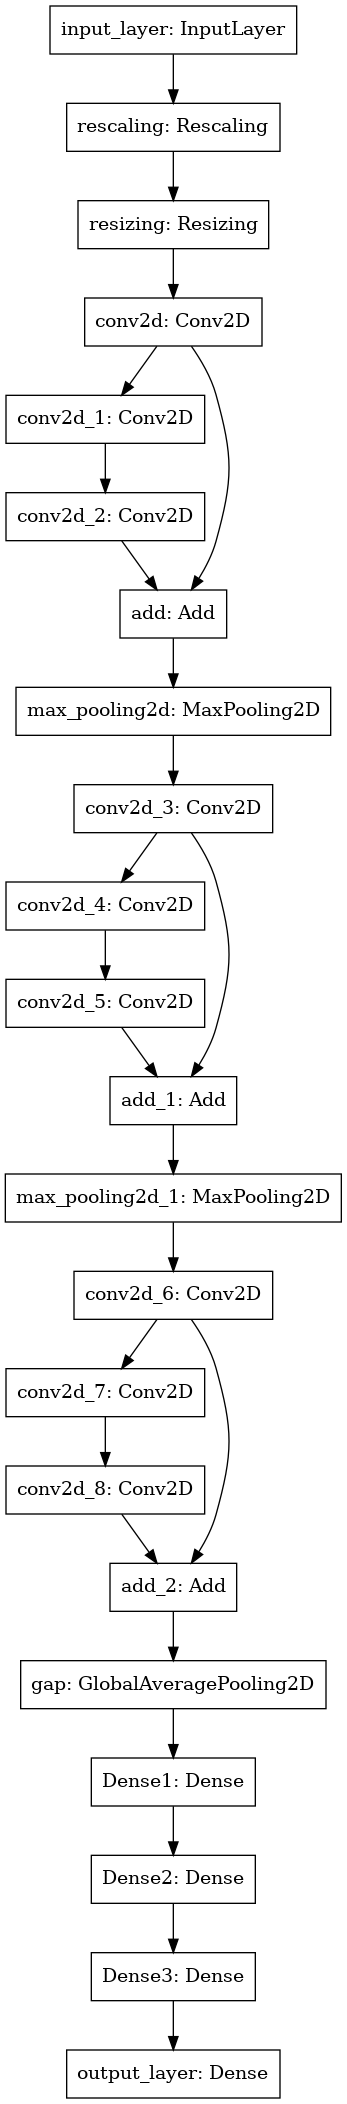

In [ ]:
tfk.utils.plot_model(model)

In [ ]:
callbacks = create_folders_and_callbacks(model_name='myModelSub2')

history = model.fit(
    x = training_set,
    epochs = epochs,
    validation_data = validation_set, 
    callbacks = callbacks,
    workers=2
).history

Epoch 1/500
89/89 [==============================] - 7s 43ms/step - loss: 2.0401 - accuracy: 0.2258 - val_loss: 1.8649 - val_accuracy: 0.2655
Epoch 2/500
89/89 [==============================] - 3s 34ms/step - loss: 1.7213 - accuracy: 0.3186 - val_loss: 1.6564 - val_accuracy: 0.3305
Epoch 3/500
89/89 [==============================] - 3s 36ms/step - loss: 1.5449 - accuracy: 0.4008 - val_loss: 1.4508 - val_accuracy: 0.4661
Epoch 4/500
89/89 [==============================] - 3s 33ms/step - loss: 1.4646 - accuracy: 0.4411 - val_loss: 1.3630 - val_accuracy: 0.4619
Epoch 5/500
89/89 [==============================] - 3s 33ms/step - loss: 1.4019 - accuracy: 0.4654 - val_loss: 1.5084 - val_accuracy: 0.4379
Epoch 6/500
89/89 [==============================] - 3s 33ms/step - loss: 1.3448 - accuracy: 0.4915 - val_loss: 1.2310 - val_accuracy: 0.5254
Epoch 7/500
89/89 [==============================] - 3s 33ms/step - loss: 1.2898 - accuracy: 0.5035 - val_loss: 1.1698 - val_accuracy: 0.5664
Epoch 

In [ ]:
final_time = datetime.now()
print("Training took %s" % (final_time - initial_time))


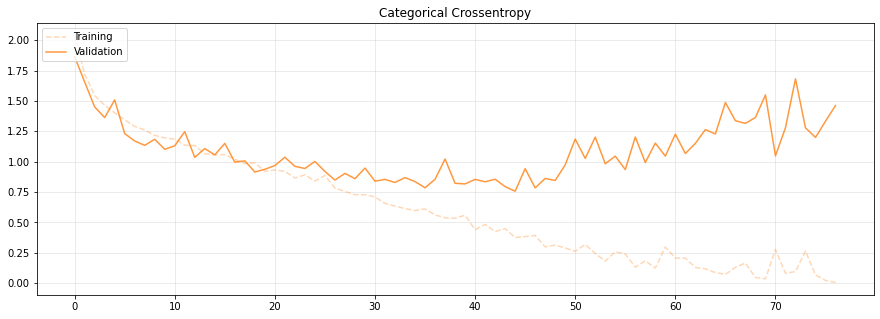

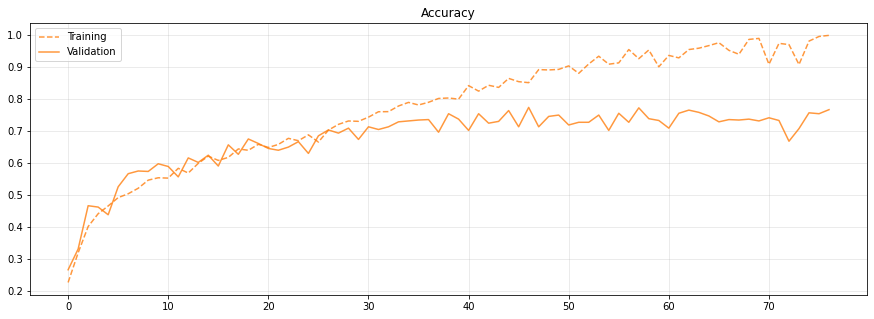

In [ ]:
# Plot the training
plt.figure(figsize=(15,5))
plt.plot(history['loss'], label='Training', alpha=.3, color='#ff7f0e', linestyle='--')
plt.plot(history['val_loss'], label='Validation', alpha=.8, color='#ff7f0e')
plt.legend(loc='upper left')
plt.title('Categorical Crossentropy')
plt.grid(alpha=.3)

plt.figure(figsize=(15,5))
plt.plot(history['accuracy'], label='Training', alpha=.8, color='#ff7f0e', linestyle='--')
plt.plot(history['val_accuracy'], label='Validation', alpha=.8, color='#ff7f0e')
plt.legend(loc='upper left')
plt.title('Accuracy')
plt.grid(alpha=.3)

plt.show()

In [ ]:
model.save("models/modelSub3")

In [ ]:
metrics = model.evaluate(validation_set, return_dict=True)
print(metrics)

23/23 [==============================] - 0s 13ms/step - loss: 0.7834 - accuracy: 0.7740
{'loss': 0.7834240794181824, 'accuracy': 0.7740113139152527}
